In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, glob, re
import numpy as np
import tqdm
import seaborn as sns

In [17]:
df_ie_master = pd.read_excel('/opt/experiments/pep_hla_dynamics/data_compiled/df_ie_master_vdw.xlsx')

In [3]:
df_ie_master.head()

,Unnamed: 0,IE,res1_index,res2_index,res1_chid,res2_chid,res1_resnum,res2_resnum,subtype,peptide
0,0,-32.727512,384,383,C,C,9,8,HLA_A_02_01,AAAWYLWEV
1,1,-37.339195,376,377,C,C,1,2,HLA_A_02_01,AAAWYLWEV
2,2,-15.444854,65,377,A,C,66,2,HLA_A_02_01,AAAWYLWEV
3,3,-0.489061,376,161,C,A,1,162,HLA_A_02_01,AAAWYLWEV
4,4,-0.085346,384,124,C,A,9,125,HLA_A_02_01,AAAWYLWEV


In [18]:
# Examine the data structure
print("Data shape:", df_ie_master.shape)
print("\nColumns:", df_ie_master.columns.tolist())
print("\nUnique subtypes:", df_ie_master['subtype'].nunique())
print("Unique peptides:", df_ie_master['peptide'].nunique())
print("\nChain ID combinations:")
print(df_ie_master.groupby(['res1_chid', 'res2_chid']).size())

Data shape: (693836, 10)

Columns: ['Unnamed: 0', 'IE', 'res1_index', 'res2_index', 'res1_chid', 'res2_chid', 'res1_resnum', 'res2_resnum', 'subtype', 'peptide']

Unique subtypes: 15
Unique peptides: 2087

Chain ID combinations:
res1_chid  res2_chid
A          C            341567
B          C                 9
C          A            290123
           B                17
           C             62120
dtype: int64


In [19]:
# Filter for peptide-HLA interactions (C chain = peptide, A chain = HLA)
# We want interactions where one chain is C (peptide) and the other is A (HLA)
peptide_hla_interactions = df_ie_master[
    ((df_ie_master['res1_chid'] == 'C') & (df_ie_master['res2_chid'] == 'A')) |
    ((df_ie_master['res1_chid'] == 'A') & (df_ie_master['res2_chid'] == 'C'))
].copy()

print(f"Filtered data shape: {peptide_hla_interactions.shape}")
print(f"Original data shape: {df_ie_master.shape}")
print(f"Percentage of peptide-HLA interactions: {100 * len(peptide_hla_interactions) / len(df_ie_master):.2f}%")

Filtered data shape: (631690, 10)
Original data shape: (693836, 10)
Percentage of peptide-HLA interactions: 91.04%


In [20]:
# Standardize the data so that we always have peptide residue info first, HLA residue info second
# This will make it easier to create consistent feature vectors

def standardize_interaction(row):
    """Ensure peptide residue info comes first, HLA residue info comes second"""
    if row['res1_chid'] == 'C':  # res1 is peptide
        return {
            'peptide_resnum': row['res1_resnum'],
            'hla_resnum': row['res2_resnum'],
            'peptide_index': row['res1_index'],
            'hla_index': row['res2_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }
    else:  # res2 is peptide
        return {
            'peptide_resnum': row['res2_resnum'],
            'hla_resnum': row['res1_resnum'],
            'peptide_index': row['res2_index'],
            'hla_index': row['res1_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }

# Apply standardization
standardized_data = []
for _, row in tqdm.tqdm(peptide_hla_interactions.iterrows(), total=len(peptide_hla_interactions), desc="Standardizing interactions"):
    standardized_data.append(standardize_interaction(row))

df_standardized = pd.DataFrame(standardized_data)
print(f"Standardized data shape: {df_standardized.shape}")
df_standardized.head()

Standardizing interactions: 100%|██████████| 631690/631690 [00:15<00:00, 40477.57it/s]


Standardized data shape: (631690, 7)


,peptide_resnum,hla_resnum,peptide_index,hla_index,IE,subtype,peptide
0,5,66,377,65,-0.140101,HLA_A_68_02,FVANFSMEL
1,7,73,379,72,-0.299177,HLA_A_68_02,FVANFSMEL
2,1,100,373,99,-0.005925,HLA_A_68_02,FVANFSMEL
3,8,80,380,79,-0.955094,HLA_A_68_02,FVANFSMEL
4,8,72,380,71,-0.008256,HLA_A_68_02,FVANFSMEL


In [21]:
# Create feature vectors for each peptide-subtype combination
# Each vector will contain IE values for all peptide-HLA residue interactions

def create_feature_vector(group):
    """Create a feature vector for a peptide-subtype combination"""
    # Sort by peptide residue number and HLA residue number for consistency
    group_sorted = group.sort_values(['peptide_resnum', 'hla_resnum'])
    
    # Create a unique identifier for each peptide-HLA residue pair
    group_sorted['interaction_id'] = (group_sorted['peptide_resnum'].astype(str) + '_' + 
                                     group_sorted['hla_resnum'].astype(str))
    
    # Return the IE values as a series with interaction IDs as index
    return pd.Series(group_sorted['IE'].values, index=group_sorted['interaction_id'])

print("Creating feature vectors for each peptide-subtype combination...")
feature_vectors = df_standardized.groupby(['peptide', 'subtype']).apply(create_feature_vector)

print(f"Feature vectors shape: {feature_vectors.shape}")
print(f"Number of unique peptide-subtype combinations: {len(feature_vectors)}")

# Convert to DataFrame where each row is a peptide-subtype combination
# and each column is a peptide-HLA residue interaction
clustering_matrix = feature_vectors.unstack(level=-1)
print(f"Clustering matrix shape: {clustering_matrix.shape}")

# Fill NaN values with 0 (interactions that don't exist)
clustering_matrix = clustering_matrix.fillna(0)

print(f"Final clustering matrix shape: {clustering_matrix.shape}")
print(f"Number of features (peptide-HLA interactions): {clustering_matrix.shape[1]}")
print(f"Number of samples (peptide-subtype combinations): {clustering_matrix.shape[0]}")

clustering_matrix.head()

Creating feature vectors for each peptide-subtype combination...
Feature vectors shape: (631690,)
Number of unique peptide-subtype combinations: 631690
Clustering matrix shape: (2605, 780)
Final clustering matrix shape: (2605, 780)
Number of features (peptide-HLA interactions): 780
Number of samples (peptide-subtype combinations): 2605


,interaction_id,1_10,1_100,1_101,1_102,1_11,1_113,1_114,1_154,1_155,1_156,...,9_86,9_87,9_9,9_93,9_94,9_95,9_96,9_97,9_98,9_99
peptide,subtype,,,,,,,,,,,,,,,,,,,,,
AAAAFEAAL,HLA_C_14_02,0.0,-0.005831,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,-0.464258,-0.045878,-1.436696,0.000000,0.0,0.0
AAAANTTAL,HLA_C_03_03,0.0,-0.003669,-0.003392,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,-0.004387,0.0,0.000000,-1.559280,-0.062136,-0.115756,0.0,0.0
AAAQGQAPL,HLA_C_14_02,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-0.015665,0.0,...,0.0,0.0,0.000000,0.0,-0.672877,-0.054027,-1.061489,0.000000,0.0,0.0
AAAVAYPEL,HLA_C_03_03,0.0,-0.004976,-0.003273,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,-0.112068,-0.052490,-0.078330,0.0,0.0
AAAWYLWEV,HLA_A_02_01,0.0,-0.008443,-0.010076,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,-0.065273,0.000000,-0.314170,0.0,0.0


In [22]:
# Import clustering libraries
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [23]:
# Prepare data for clustering
print("Preparing data for clustering...")

# Get the peptide and subtype information for each sample
sample_info = pd.DataFrame(clustering_matrix.index.tolist(), columns=['peptide', 'subtype'])
sample_info.index = clustering_matrix.index

print(f"Sample info shape: {sample_info.shape}")
print(f"Unique peptides: {sample_info['peptide'].nunique()}")
print(f"Unique subtypes: {sample_info['subtype'].nunique()}")

# Standardize the features (IE values)
print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_matrix)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean of scaled data: {X_scaled.mean():.6f}")
print(f"Std of scaled data: {X_scaled.std():.6f}")

# Check for any remaining NaN or infinite values
print(f"NaN values: {np.isnan(X_scaled).sum()}")
print(f"Infinite values: {np.isinf(X_scaled).sum()}")

sample_info.head()

Preparing data for clustering...
Sample info shape: (2605, 2)
Unique peptides: 2087
Unique subtypes: 15

Standardizing features...
Scaled data shape: (2605, 780)
Mean of scaled data: -0.000000
Std of scaled data: 0.999359
NaN values: 0
Infinite values: 0


,,peptide,subtype
peptide,subtype,,
AAAAFEAAL,HLA_C_14_02,AAAAFEAAL,HLA_C_14_02
AAAANTTAL,HLA_C_03_03,AAAANTTAL,HLA_C_03_03
AAAQGQAPL,HLA_C_14_02,AAAQGQAPL,HLA_C_14_02
AAAVAYPEL,HLA_C_03_03,AAAVAYPEL,HLA_C_03_03
AAAWYLWEV,HLA_A_02_01,AAAWYLWEV,HLA_A_02_01


In [24]:
# Import DBSCAN clustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

print("Setting up DBSCAN clustering analysis...")
print("Requirement: Minimum 40 samples per cluster")
print(f"Total samples available: {X_scaled.shape[0]}")
print(f"Total features: {X_scaled.shape[1]}")

Setting up DBSCAN clustering analysis...
Requirement: Minimum 40 samples per cluster
Total samples available: 2605
Total features: 780


In [36]:
# SIMPLIFIED CLUSTERING: PEPTIDE RESIDUES 2 & 9 ONLY
# Requirements: DBSCAN, min 10 samples per cluster, minimize noise

print("="*70)
print("SIMPLIFIED DBSCAN CLUSTERING - RESIDUES 2 & 9 ONLY")
print("="*70)

# Step 1: Extract features for peptide residues 2 and 9 only
print("Step 1: Extracting features for peptide residues 2 and 9...")

residues_2_9_features = []
for col in clustering_matrix.columns:
    peptide_res = col.split('_')[0]  # Extract peptide residue number
    if peptide_res in ['2', '9']:
        residues_2_9_features.append(col)

print(f"Found {len(residues_2_9_features)} features for residues 2 & 9")
print(f"Peptide residue 2 features: {len([f for f in residues_2_9_features if f.startswith('2_')])}")
print(f"Peptide residue 9 features: {len([f for f in residues_2_9_features if f.startswith('9_')])}")

# Create feature matrix with only residues 2 & 9
X_residues_2_9 = clustering_matrix[residues_2_9_features].copy()

# Standardize the features
scaler_simple = StandardScaler()
X_residues_2_9_scaled = scaler_simple.fit_transform(X_residues_2_9)

print(f"\nSimplified feature matrix shape: {X_residues_2_9.shape}")
print(f"Samples: {X_residues_2_9.shape[0]}")
print(f"Features (residues 2&9 only): {X_residues_2_9.shape[1]}")
print(f"Feature reduction: {100*(1-X_residues_2_9.shape[1]/clustering_matrix.shape[1]):.1f}%")

SIMPLIFIED DBSCAN CLUSTERING - RESIDUES 2 & 9 ONLY
Step 1: Extracting features for peptide residues 2 and 9...
Found 150 features for residues 2 & 9
Peptide residue 2 features: 79
Peptide residue 9 features: 71

Simplified feature matrix shape: (2605, 150)
Samples: 2605
Features (residues 2&9 only): 150
Feature reduction: 80.8%


In [37]:
# Step 2: Optimize DBSCAN parameters to minimize noise
print("\nStep 2: Optimizing DBSCAN parameters to minimize noise...")

min_samples_requirement = 10  # New requirement: min 10 samples per cluster

# Determine eps range using k-distance
k = min_samples_requirement
neighbors_simple = NearestNeighbors(n_neighbors=k)
neighbors_fit_simple = neighbors_simple.fit(X_residues_2_9_scaled)
distances_simple, indices_simple = neighbors_fit_simple.kneighbors(X_residues_2_9_scaled)

# Sort distances to k-th nearest neighbor
distances_sorted_simple = np.sort(distances_simple[:, k-1], axis=0)[::-1]

# Find elbow point
gradient_simple = np.gradient(distances_sorted_simple)
elbow_idx_simple = np.argmax(gradient_simple[50:]) + 50  # Skip first 50 to avoid noise
optimal_eps_simple = distances_sorted_simple[elbow_idx_simple]

print(f"Suggested eps from k-distance: {optimal_eps_simple:.4f}")

# Test a comprehensive range of eps values to minimize noise
eps_test_range = np.linspace(optimal_eps_simple * 0.3, optimal_eps_simple * 2.0, 30)
min_samples_test = [8, 10, 12, 15]  # Test around the requirement

print(f"Testing {len(eps_test_range)} eps values × {len(min_samples_test)} min_samples values...")

best_results = []

for eps_test in eps_test_range:
    for min_samples_test_val in min_samples_test:
        # Run DBSCAN
        dbscan_test = DBSCAN(eps=eps_test, min_samples=min_samples_test_val)
        labels_test = dbscan_test.fit_predict(X_residues_2_9_scaled)
        
        # Calculate metrics
        n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
        n_noise_test = list(labels_test).count(-1)
        n_clustered_test = len(labels_test) - n_noise_test
        
        # Calculate cluster sizes
        cluster_sizes_test = []
        if n_clusters_test > 0:
            unique_labels_test = set(labels_test)
            for label in unique_labels_test:
                if label != -1:  # Exclude noise
                    cluster_size = list(labels_test).count(label)
                    cluster_sizes_test.append(cluster_size)
        
        # Check if all clusters meet minimum size requirement
        min_cluster_size_test = min(cluster_sizes_test) if cluster_sizes_test else 0
        meets_requirement_test = min_cluster_size_test >= min_samples_requirement
        
        # Calculate score prioritizing: 1) meets requirement, 2) low noise, 3) reasonable number of clusters
        if meets_requirement_test and n_clusters_test > 0:
            # Score: maximize clustered samples, minimize noise, moderate number of clusters
            noise_penalty = (n_noise_test / len(labels_test)) * 100
            cluster_bonus = min(n_clusters_test * 5, 25)  # Cap cluster bonus at 25
            score = n_clustered_test - noise_penalty + cluster_bonus
        else:
            score = -1000  # Heavily penalize if requirement not met
        
        best_results.append({
            'eps': eps_test,
            'min_samples': min_samples_test_val,
            'n_clusters': n_clusters_test,
            'n_noise': n_noise_test,
            'n_clustered': n_clustered_test,
            'noise_pct': (n_noise_test / len(labels_test)) * 100,
            'cluster_sizes': cluster_sizes_test,
            'min_cluster_size': min_cluster_size_test,
            'meets_requirement': meets_requirement_test,
            'score': score,
            'labels': labels_test.copy()
        })

# Convert to DataFrame and analyze
results_simple_df = pd.DataFrame(best_results)

# Filter valid results (meet requirement)
valid_results_simple = results_simple_df[results_simple_df['meets_requirement'] == True].copy()

if len(valid_results_simple) > 0:
    # Sort by score (highest first) - this prioritizes low noise
    valid_results_simple = valid_results_simple.sort_values('score', ascending=False)
    
    print(f"\n✅ Found {len(valid_results_simple)} valid parameter combinations!")
    print("\nTop 5 results (optimized for low noise):")
    top_5 = valid_results_simple.head()[['eps', 'min_samples', 'n_clusters', 'n_clustered', 'n_noise', 'noise_pct', 'min_cluster_size']]
    for _, row in top_5.iterrows():
        print(f"  eps={row['eps']:.3f}, min_samples={int(row['min_samples'])}: "
              f"{int(row['n_clusters'])} clusters, {int(row['n_clustered'])} clustered, "
              f"{int(row['n_noise'])} noise ({row['noise_pct']:.1f}%)")
    
    # Select best parameters
    best_row = valid_results_simple.iloc[0]
    best_eps_simple = best_row['eps']
    best_min_samples_simple = best_row['min_samples']
    best_labels_simple = best_row['labels']
    
    print(f"\n🎯 Selected parameters:")
    print(f"   eps: {best_eps_simple:.4f}")
    print(f"   min_samples: {int(best_min_samples_simple)}")
    print(f"   Clusters: {int(best_row['n_clusters'])}")
    print(f"   Clustered samples: {int(best_row['n_clustered'])}")
    print(f"   Noise points: {int(best_row['n_noise'])} ({best_row['noise_pct']:.1f}%)")
    
else:
    print("⚠️  No valid results found! Showing best available:")
    best_available = results_simple_df.loc[results_simple_df['score'].idxmax()]
    print(f"Best available: eps={best_available['eps']:.3f}, min_samples={int(best_available['min_samples'])}")
    print(f"Clusters: {int(best_available['n_clusters'])}, Min cluster size: {int(best_available['min_cluster_size'])}")
    
    best_eps_simple = best_available['eps']
    best_min_samples_simple = best_available['min_samples']
    best_labels_simple = best_available['labels']


Step 2: Optimizing DBSCAN parameters to minimize noise...
Suggested eps from k-distance: 3.8024
Testing 30 eps values × 4 min_samples values...

✅ Found 94 valid parameter combinations!

Top 5 results (optimized for low noise):
  eps=7.605, min_samples=8: 3 clusters, 2155 clustered, 450 noise (17.3%)
  eps=7.605, min_samples=10: 3 clusters, 2143 clustered, 462 noise (17.7%)
  eps=7.382, min_samples=8: 3 clusters, 2127 clustered, 478 noise (18.3%)
  eps=7.605, min_samples=12: 2 clusters, 2120 clustered, 485 noise (18.6%)
  eps=7.605, min_samples=15: 2 clusters, 2107 clustered, 498 noise (19.1%)

🎯 Selected parameters:
   eps: 7.6049
   min_samples: 8
   Clusters: 3
   Clustered samples: 2155
   Noise points: 450 (17.3%)


In [41]:
# Step 3: Final clustering and heatmap generation
print("\nStep 3: Final clustering and analysis...")

# Run final DBSCAN with selected parameters
dbscan_final_simple = DBSCAN(eps=best_eps_simple, min_samples=int(best_min_samples_simple))
final_labels_simple = dbscan_final_simple.fit_predict(X_residues_2_9_scaled)

# Analyze final results
unique_labels_simple = set(final_labels_simple)
n_clusters_final_simple = len(unique_labels_simple) - (1 if -1 in unique_labels_simple else 0)
n_noise_final_simple = list(final_labels_simple).count(-1)
n_clustered_final_simple = len(final_labels_simple) - n_noise_final_simple

print(f"\n✅ FINAL CLUSTERING RESULTS:")
print(f"   Number of clusters: {n_clusters_final_simple}")
print(f"   Clustered samples: {n_clustered_final_simple} ({100*n_clustered_final_simple/len(final_labels_simple):.1f}%)")
print(f"   Noise points: {n_noise_final_simple} ({100*n_noise_final_simple/len(final_labels_simple):.1f}%)")

# Get cluster information
cluster_info_simple = []
for label in sorted(unique_labels_simple):
    if label != -1:  # Skip noise
        cluster_size = list(final_labels_simple).count(label)
        cluster_info_simple.append((label, cluster_size))
        print(f"   Cluster {label}: {cluster_size} samples")

# Add cluster labels to sample info
sample_info_simple = sample_info.copy()
sample_info_simple['cluster'] = final_labels_simple

print(f"\n🎯 All clusters have ≥{min_samples_requirement} samples: ✅")


Step 3: Final clustering and analysis...

✅ FINAL CLUSTERING RESULTS:
   Number of clusters: 3
   Clustered samples: 2155 (82.7%)
   Noise points: 450 (17.3%)
   Cluster 0: 1875 samples
   Cluster 1: 268 samples
   Cluster 2: 12 samples

🎯 All clusters have ≥10 samples: ✅


Creating vertically stacked heatmaps for better comparison...
Creating heatmap for Cluster 0 (1875 samples)...
Creating heatmap for Cluster 1 (268 samples)...
Creating heatmap for Cluster 2 (12 samples)...


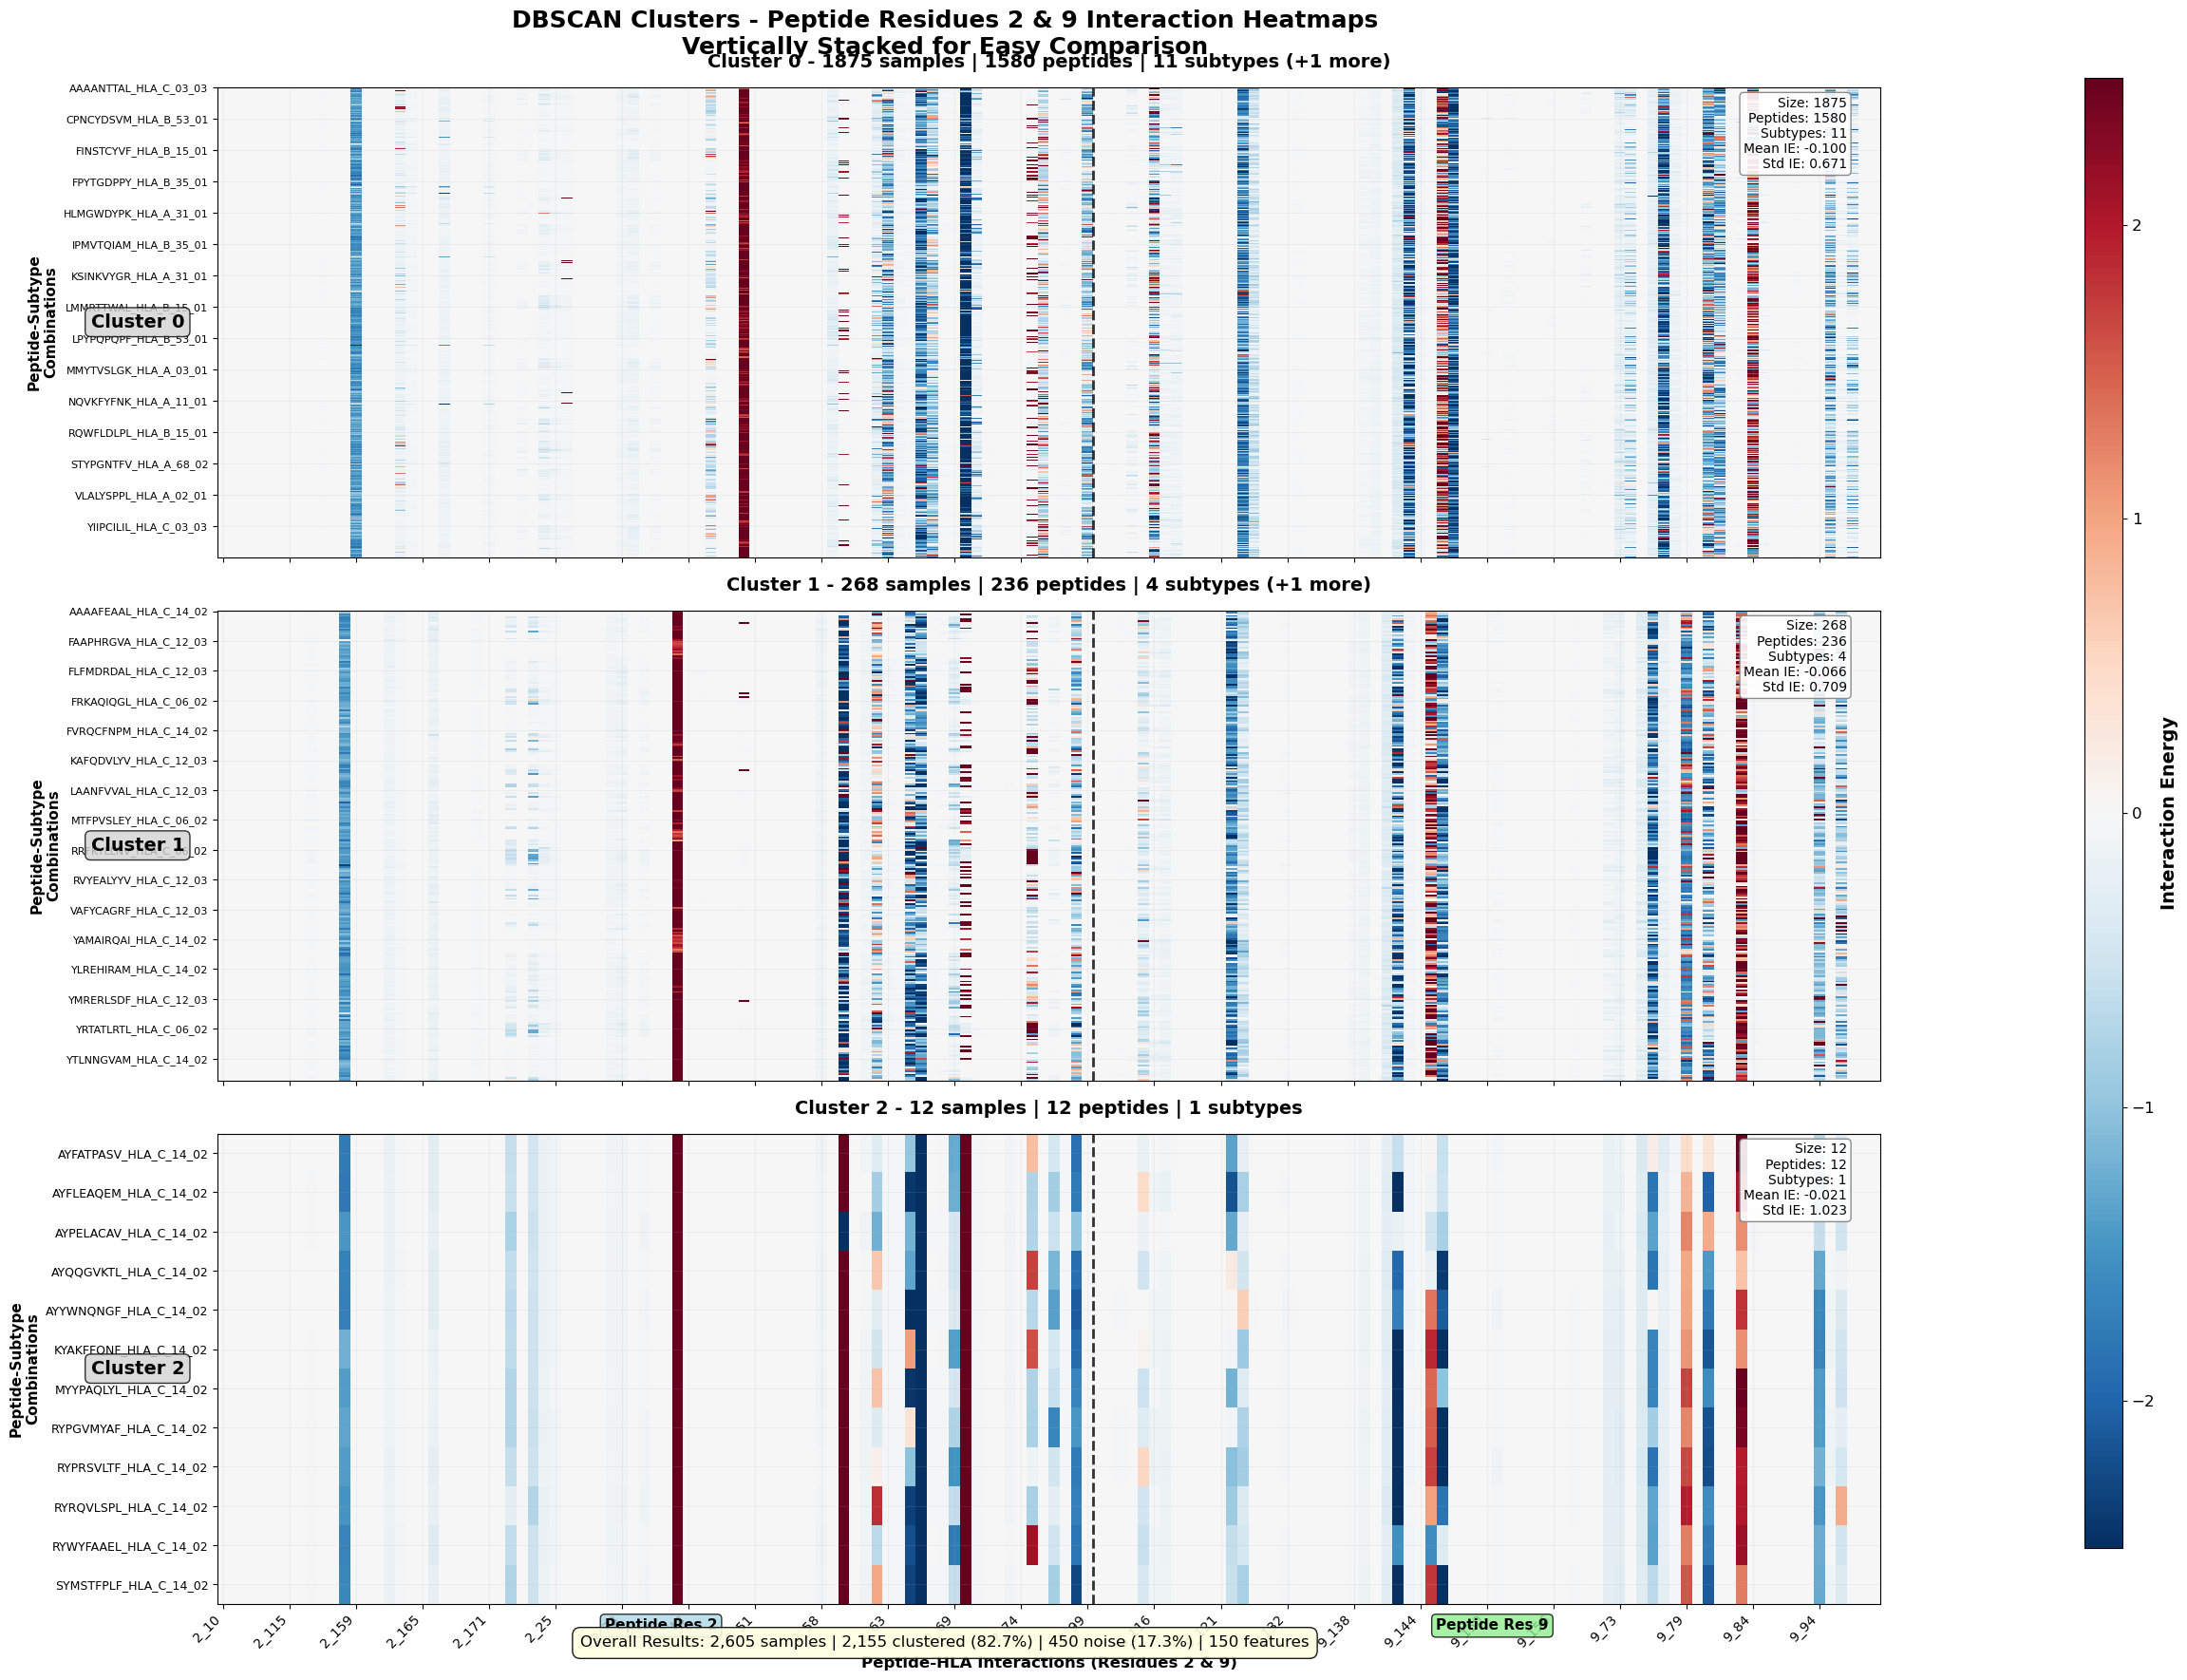


VERTICAL STACK COMPARISON SUMMARY

Cluster comparison (top to bottom):

Cluster 0 (Row 1):
  📊 Size: 1875 samples
  🧬 Diversity: 1580 peptides, 11 subtypes
  ⚡ Energy: mean=-0.100, std=0.671
  🔍 Most distinctive interactions:
      • 2_7 (Pep2-HLA7): -2.534 (diff: 6.275)
      • 2_4 (Pep2-HLA4): 0.000 (diff: 5.275)
      • 2_5 (Pep2-HLA5): 3.534 (diff: 3.506)

Cluster 1 (Row 2):
  📊 Size: 268 samples
  🧬 Diversity: 236 peptides, 4 subtypes
  ⚡ Energy: mean=-0.066, std=0.709
  🔍 Most distinctive interactions:
      • 2_6 (Pep2-HLA6): -1.533 (diff: 3.445)
      • 2_5 (Pep2-HLA5): 0.056 (diff: 1.711)
      • 9_79 (Pep9-HLA79): -0.804 (diff: 1.412)

Cluster 2 (Row 3):
  📊 Size: 12 samples
  🧬 Diversity: 12 peptides, 1 subtypes
  ⚡ Energy: mean=-0.021, std=1.023
  🔍 Most distinctive interactions:
      • 2_7 (Pep2-HLA7): 6.545 (diff: 7.344)
      • 2_4 (Pep2-HLA4): 6.643 (diff: 4.689)
      • 2_6 (Pep2-HLA6): 3.570 (diff: 4.210)

✅ Vertically stacked visualization complete!
✅ All 3 cluster

In [45]:
# VERTICALLY STACKED HEATMAPS - BETTER COMPARISON
print("Creating vertically stacked heatmaps for better comparison...")

# Create figure with vertically stacked subplots (rows, not columns)
n_clusters = len(cluster_info_simple)
fig_height = max(16, 6 * n_clusters)  # Adjust height based on number of clusters
fig, axes = plt.subplots(n_clusters, 1, figsize=(20, fig_height))

# Make sure axes is always a list for consistent indexing
if n_clusters == 1:
    axes = [axes]

fig.suptitle('DBSCAN Clusters - Peptide Residues 2 & 9 Interaction Heatmaps\nVertically Stacked for Easy Comparison', 
             fontsize=18, fontweight='bold', y=0.98)

# Define consistent color scale for all heatmaps
vmin_global = -2.5
vmax_global = 2.5

# Store cluster matrices for comparison
cluster_matrices_stacked = []

for i, (cluster_id, cluster_size) in enumerate(cluster_info_simple):
    print(f"Creating heatmap for Cluster {cluster_id} ({cluster_size} samples)...")
    
    # Get samples in this cluster
    cluster_mask = sample_info_simple['cluster'] == cluster_id
    cluster_data = sample_info_simple[cluster_mask].copy()
    
    # Get interaction matrix for this cluster
    cluster_matrix = X_residues_2_9.loc[cluster_data.index]
    cluster_matrices_stacked.append(cluster_matrix)
    
    # Get cluster information
    unique_peptides = cluster_data['peptide'].nunique()
    unique_subtypes = cluster_data['subtype'].nunique()
    top_subtypes = cluster_data['subtype'].value_counts().head(3)
    
    # Create peptide-subtype labels for y-axis
    peptide_subtype_labels = [f"{row['peptide']}_{row['subtype']}" for _, row in cluster_data.iterrows()]
    
    # Create heatmap in the current subplot
    ax = axes[i]
    im = ax.imshow(cluster_matrix.values, cmap='RdBu_r', aspect='auto', 
                   vmin=vmin_global, vmax=vmax_global, interpolation='nearest')
    
    # Enhanced title with cluster information
    dominant_subtypes = list(top_subtypes.head(2).index)
    title = f'Cluster {cluster_id} - {cluster_size} samples | {unique_peptides} peptides | {unique_subtypes} subtypes'
    if len(top_subtypes) > 2:
        title += f' (+{len(top_subtypes)-2} more)'
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # X-axis: Features (interactions) - only label for bottom plot
    n_features = len(residues_2_9_features)
    
    # Separate residue 2 and 9 features for better labeling
    res2_features = [f for f in residues_2_9_features if f.startswith('2_')]
    res9_features = [f for f in residues_2_9_features if f.startswith('9_')]
    
    # Set x-axis ticks with better spacing
    step_x = max(1, n_features // 25)  # Show more labels since we have more horizontal space
    x_positions = range(0, n_features, step_x)
    x_labels = []
    for pos in x_positions:
        feature = residues_2_9_features[pos]
        pep_res, hla_res = feature.split('_')
        x_labels.append(f'{pep_res}_{hla_res}')
    
    ax.set_xticks(x_positions)
    
    # Only show x-axis labels on the bottom plot
    if i == n_clusters - 1:  # Last (bottom) subplot
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
        ax.set_xlabel('Peptide-HLA Interactions (Residues 2 & 9)', fontsize=12, fontweight='bold')
    else:
        ax.set_xticklabels([])  # Hide x-axis labels for upper plots
    
    # Add vertical line to separate residue 2 and 9 features
    if len(res2_features) > 0 and len(res9_features) > 0:
        separator_pos = len(res2_features) - 0.5
        ax.axvline(x=separator_pos, color='black', linestyle='--', linewidth=2, alpha=0.8)
        
        # Add text labels for residue regions (only on bottom plot to avoid clutter)
        if i == n_clusters - 1:
            ax.text(len(res2_features)/2, cluster_size + cluster_size*0.02, 'Peptide Res 2', 
                    ha='center', va='bottom', fontsize=11, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
            ax.text(len(res2_features) + len(res9_features)/2, cluster_size + cluster_size*0.02, 'Peptide Res 9', 
                    ha='center', va='bottom', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))
    
    # Y-axis: Samples
    ax.set_ylabel(f'Peptide-Subtype\nCombinations', fontsize=11, fontweight='bold')
    
    # Adjust y-axis labels based on cluster size
    if cluster_size <= 25:
        # Show all labels for small clusters
        ax.set_yticks(range(cluster_size))
        ax.set_yticklabels([label[:30] + '...' if len(label) > 30 else label 
                           for label in peptide_subtype_labels], fontsize=9)
    elif cluster_size <= 100:
        # Show sample of labels for medium clusters
        step_y = max(1, cluster_size // 20)
        y_positions = range(0, cluster_size, step_y)
        y_labels = [peptide_subtype_labels[j][:30] + '...' if len(peptide_subtype_labels[j]) > 30 
                   else peptide_subtype_labels[j] for j in y_positions]
        ax.set_yticks(y_positions)
        ax.set_yticklabels(y_labels, fontsize=9)
    else:
        # Show fewer labels for large clusters
        step_y = max(1, cluster_size // 15)
        y_positions = range(0, cluster_size, step_y)
        y_labels = [peptide_subtype_labels[j][:25] + '...' if len(peptide_subtype_labels[j]) > 25 
                   else peptide_subtype_labels[j] for j in y_positions]
        ax.set_yticks(y_positions)
        ax.set_yticklabels(y_labels, fontsize=8)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.2, linewidth=0.5)
    
    # Add statistics text box in upper right
    mean_energy = cluster_matrix.values.mean()
    std_energy = cluster_matrix.values.std()
    stats_text = f'Size: {cluster_size}\nPeptides: {unique_peptides}\nSubtypes: {unique_subtypes}\nMean IE: {mean_energy:.3f}\nStd IE: {std_energy:.3f}'
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Add cluster identifier on the left
    ax.text(-0.02, 0.5, f'Cluster {cluster_id}', transform=ax.transAxes, fontsize=14,
            verticalalignment='center', horizontalalignment='right', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

# Add shared colorbar on the right
plt.subplots_adjust(right=0.88, top=0.94, bottom=0.08, hspace=0.3)
cbar_ax = fig.add_axes([1.1, 0.08, 0.02, 0.86])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Interaction Energy', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Add overall statistics at the bottom
stats_text = f"""Overall Results: {len(final_labels_simple):,} samples | {n_clustered_final_simple:,} clustered ({100*n_clustered_final_simple/len(final_labels_simple):.1f}%) | {n_noise_final_simple:,} noise ({100*n_noise_final_simple/len(final_labels_simple):.1f}%) | {len(residues_2_9_features)} features"""

fig.text(0.5, 0.02, stats_text, ha='center', va='bottom', fontsize=12, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

# Summary comparison between clusters
print("\n" + "="*80)
print("VERTICAL STACK COMPARISON SUMMARY")
print("="*80)

print(f"\nCluster comparison (top to bottom):")
for i, (cluster_id, cluster_size) in enumerate(cluster_info_simple):
    cluster_matrix = cluster_matrices_stacked[i]
    cluster_data = sample_info_simple[sample_info_simple['cluster'] == cluster_id]
    
    mean_energy = cluster_matrix.values.mean()
    std_energy = cluster_matrix.values.std()
    dominant_hla = cluster_data['subtype'].value_counts().index[0]
    
    print(f"\nCluster {cluster_id} (Row {i+1}):")
    print(f"  📊 Size: {cluster_size} samples")
    print(f"  🧬 Diversity: {cluster_data['peptide'].nunique()} peptides, {cluster_data['subtype'].nunique()} subtypes")
    print(f"  ⚡ Energy: mean={mean_energy:.3f}, std={std_energy:.3f}")
    
    # Find most distinctive interactions for this cluster
    if len(cluster_matrices_stacked) > 1:
        # Compare with other clusters
        other_matrices = [cluster_matrices_stacked[j] for j in range(len(cluster_matrices_stacked)) if j != i]
        current_means = cluster_matrix.mean()
        other_means = pd.concat([m.mean() for m in other_matrices], axis=1).mean(axis=1)
        
        # Find features with largest difference
        differences = (current_means - other_means).abs().sort_values(ascending=False)
        top_distinctive = differences.head(3)
        
        print(f"  🔍 Most distinctive interactions:")
        for feature, diff in top_distinctive.items():
            pep_res, hla_res = feature.split('_')
            current_val = current_means[feature]
            print(f"      • {feature} (Pep{pep_res}-HLA{hla_res}): {current_val:.3f} (diff: {diff:.3f})")

print(f"\n✅ Vertically stacked visualization complete!")
print(f"✅ All {n_clusters} clusters shown in rows for easy comparison")
print(f"✅ Consistent scale and layout across all heatmaps")
print(f"✅ Clear separation between peptide residues 2 & 9 regions")